In [1]:
import deeplabcut as dlc
import random
import shutil
import glob
import os

# From paths.py
import paths

Loading DLC 2.3rc3...


In [2]:
# Find all videos in the data directory with VTuning in the name
all_videos = glob.glob(paths.vrexperiment_path + os.sep + "*VTuningWF*.avi")

# If Project already created, run the cell below

In [6]:
# Get config path
# config_path = paths.config_path_VTuningWF
config_path = r"D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\config.yaml"

# Read config file
cfg = dlc.auxiliaryfunctions.read_config(config_path)

# Get project directory
project_directory = cfg['project_path']

# Get list of local videos as found in the config
project_video_list = [vid for vid in cfg["video_sets"]]
test_video_dir = os.path.join(project_directory, "test-videos")
test_vids = glob.glob(test_video_dir + os.sep + "*.avi")
test_vids += glob.glob(test_video_dir + os.sep + "*.mp4")
test_vids = [vid for vid in test_vids if "labeled" not in vid]

# If you haven't created a new project, run this cell

In [ ]:
dlc.create_new_project?

In [ ]:
# Randomly select 15 videos to train on
remote_video_list = []
for i in range(4):
    remote_video_list.append(random.choice(all_videos))

dlc.create_new_project("VTuningWF", "Matt", remote_video_list, working_directory=r"D:\DLC_projects\vtuning_wirefree", copy_videos=True)

In [ ]:
# Get config and path info
config_path = paths.config_path_VTuningWF
cfg = dlc.auxiliaryfunctions.read_config(config_path)
project_directory = cfg['project_path']
project_video_list = [vid for vid in cfg["video_sets"]]

In [ ]:
# Randomly pick videos to test the network that are not part of the training set and copy to the project directory
test_video_dir = os.path.join(project_directory, "test-videos")
if not os.path.isdir(test_video_dir):
    os.mkdir(test_video_dir)

# Randomly pick five videos outside of the training set to test the network on
test_vids = []
while(len(test_vids) < 5):
    vid = random.choice(all_videos)
    if vid not in project_video_list:
        dest = shutil.copy2(vid, test_video_dir)
        test_vids.append(dest)
        
test_vids = glob.glob(test_video_dir + os.sep + "*VTuningWF*.avi")

In [ ]:
test_vids

# Add extra videos (if needed)

In [ ]:
dlc.add_new_videos?

In [ ]:
# If adding new videos, do that here by randomly selecting some not in the original data set or the test set
# For this particular case, we want videos that are older than March 12th 2022
from datetime import datetime
from os.path import sep

valid_extras = [vid for vid in all_videos if datetime.strptime(vid.split(sep)[-1].split('_VTuningWF')[0], "%m_%d_%Y_%H_%M_%S") > datetime(2022, 3, 12)]

extra_vids = []
while(len(extra_vids) < 2):
    vid = random.choice(valid_extras)
    if vid not in project_video_list or test_vids:
        extra_vids.append(vid)
        
dlc.add_new_videos(config_path, extra_vids, copy_videos=True)

# Extract and label frames

In [ ]:
dlc.extract_frames?

In [ ]:
# extract frames from the videos
# will go through all of the videos on the list, so if many videos, it might take a while
dlc.extract_frames(config_path, mode='automatic', algo='kmeans', crop=False, userfeedback=True);

In [ ]:
# label frames
# generates folders in the labeled-data folder with the video name
dlc.label_frames(config_path)

In [ ]:
# check the labels
# generates folders in the labeled-data folder with the video name but the actual labels printed on the pics
dlc.check_labels(config_path, draw_skeleton=False);

In [ ]:
# Used if need to |reconstruct labeling h5 files from csvs
dlc.convertcsv2h5(config_path)

In [6]:
dlc.create_training_dataset?

In [7]:
# create the training set
# also creates the Pose.yaml in the dlc-models/train dataset, which contains the setting for training, i.e. take a look
dlc.create_training_dataset(config_path, num_shuffles=3,
                            augmenter_type='imgaug',
                            net_type='resnet_50',
                            posecfg_template=r"D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\pose_cfg.yaml"
                            );

Reloading pose_cfg parameters from D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\pose_cfg.yaml

Utilizing the following graph: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [2, 3], [2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [4, 5], [4, 6], [5, 6]]
Creating training data for: Shuffle: 1 TrainFraction:  0.95


100%|███████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 3911.69it/s]


The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!
Creating training data for: Shuffle: 2 TrainFraction:  0.95


100%|██████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 16625.21it/s]


The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!
Creating training data for: Shuffle: 3 TrainFraction:  0.95


100%|██████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 16624.22it/s]

The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


In [8]:
dlc.train_network?

In [9]:
# train the network
dlc.train_network(config_path, shuffle=2,
                  gputouse=0, allow_growth=True,
                  max_snapshots_to_keep=5, displayiters=5e3, saveiters=25e3, maxiters=200e3)

Config:
{'all_joints': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11]],
 'all_joints_names': ['mouseSnout',
                      'mouseBarL',
                      'mouseBarR',
                      'mouseBody1',
                      'mouseBody2',
                      'mouseBody3',
                      'mouseBase',
                      'miniscope',
                      'corner_UL',
                      'corner_UR',
                      'corner_BR',
                      'corner_BL'],
 'alpha_r': 0.02,
 'apply_prob': 0.5,
 'batch_size': 8,
 'contrast': {'clahe': True,
              'claheratio': 0.1,
              'histeq': True,
              'histeqratio': 0.1},
 'convolution': {'edge': False,
                 'emboss': {'alpha': [0.0, 1.0], 'strength': [0.5, 1.5]},
                 'embossratio': 0.1,
                 'sharpen': False,
                 'sharpenratio': 0.3},
 'crop_pad': 0,
 'crop_sampling': 'hybrid',
 'crop_size': [400, 400],
 'cropratio': 0.4,

Selecting multi-animal trainer
Activating limb prediction...
Batch Size is 8
Getting specs multi-animal-imgaug 21 12


C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Loading already trained DLC with backbone: resnet_50
Max_iters overwritten as 200000
Display_iters overwritten as 5000
Save_iters overwritten as 25000
Training parameters:
{'stride': 8.0, 'weigh_part_predictions': False, 'weigh_negatives': False, 'fg_fraction': 0.25, 'mean_pixel': [123.68, 116.779, 103.939], 'shuffle': True, 'snapshot_prefix': 'D:\\DLC_projects\\vtuning_wirefree_DLC_22\\VTuningWF-Matt-2022-10-25\\dlc-models\\iteration-4\\VTuningWFOct25-trainset95shuffle2\\train\\snapshot', 'log_dir': 'log', 'global_scale': 0.8, 'location_refinement': True, 'locref_stdev': 7.2801, 'locref_loss_weight': 0.05, 'locref_huber_loss': True, 'optimizer': 'adam', 'intermediate_supervision': False, 'intermediate_supervision_layer': 12, 'regularize': False, 'weight_decay': 0.0001, 'crop_pad': 0, 'scoremap_dir': 'test', 'batch_size': 8, 'dataset_type': 'multi-animal-imgaug', 'deterministic': False, 'mirror': False, 'pairwise_huber_loss': False, 'weigh_only_present_joints': False, 'partaffinityfiel

iteration: 110000 loss: 0.0009 scmap loss: 0.0008 locref loss: 0.0000 limb loss: 0.0000 lr: 0.0001
iteration: 115000 loss: 0.0007 scmap loss: 0.0007 locref loss: 0.0000 limb loss: 0.0000 lr: 5e-05
iteration: 120000 loss: 0.0006 scmap loss: 0.0006 locref loss: 0.0000 limb loss: 0.0000 lr: 1e-05
iteration: 125000 loss: 0.0006 scmap loss: 0.0005 locref loss: 0.0000 limb loss: 0.0000 lr: 1e-05
iteration: 130000 loss: 0.0005 scmap loss: 0.0005 locref loss: 0.0000 limb loss: 0.0000 lr: 1e-05
iteration: 135000 loss: 0.0005 scmap loss: 0.0005 locref loss: 0.0000 limb loss: 0.0000 lr: 1e-05
iteration: 140000 loss: 0.0005 scmap loss: 0.0005 locref loss: 0.0000 limb loss: 0.0000 lr: 1e-05
iteration: 145000 loss: 0.0005 scmap loss: 0.0005 locref loss: 0.0000 limb loss: 0.0000 lr: 1e-05
iteration: 150000 loss: 0.0005 scmap loss: 0.0005 locref loss: 0.0000 limb loss: 0.0000 lr: 1e-05
iteration: 155000 loss: 0.0005 scmap loss: 0.0005 locref loss: 0.0000 limb loss: 0.0000 lr: 1e-05
iteration: 160000 l

The network is now trained and ready to evaluate. Use the function 'evaluate_network' to evaluate the network.


Config:
{'all_joints': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11]],
 'all_joints_names': ['mouseSnout',
                      'mouseBarL',
                      'mouseBarR',
                      'mouseBody1',
                      'mouseBody2',
                      'mouseBody3',
                      'mouseBase',
                      'miniscope',
                      'corner_UL',
                      'corner_UR',
                      'corner_BR',
                      'corner_BL'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-4\\UnaugmentedDataSet_VTuningWFOct25\\VTuningWF_Matt95shuffle2.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': 'C:\\Users\\mmccann\\Miniconda3\\envs\\DEEPLABCUT\\lib\\site-packages\\deeplabcut\\pose_estimation_tensorflow\\models\\pretrained\\resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_

Running  DLC_resnet50_VTuningWFOct25shuffle2_305000  with # of trainingiterations: 305000
Activating extracting of PAFs
Network Evaluation underway...


140it [00:55,  2.54it/s]


Results for 305000 training iterations, training fraction of 95, and shuffle 2:
Train error: 3.34 pixels. Test error: 3.45 pixels.
With pcutoff of 0.85:
Train error: 3.34 pixels. Test error: 3.45 pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels; test-only)
individuals
mouse1    3.430731
single    3.462453
Average Euclidean distance to GT per bodypart (in pixels; test-only)
bodyparts
corner_BL     1.992174
corner_BR     3.036912
corner_UL     3.618346
corner_UR     2.396295
miniscope     6.193004
mouseBarL     3.912100
mouseBarR     2.731302
mouseBase     2.383219
mouseBody1    3.910953
mouseBody2    4.208563
mouseBody3    3.293982
mouseSnout    4.313094
Done and results stored for snapshot:  snapshot-305000
Selecting best skeleton...


C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\deeplabcut\pose_estimation_tensorflow\lib\crossvalutils.py:83: RuntimeWarning: invalid value encountered in true_divide
  hist_left = hist_left / hist_left.sum()


Graph 1|10


140it [00:00, 5599.82it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 46651.51it/s]


Graph 2|10


140it [00:00, 5832.94it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 69955.03it/s]


Graph 3|10


140it [00:00, 5600.73it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 46677.47it/s]


Graph 4|10


140it [00:00, 5833.12it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 70005.07it/s]


Graph 5|10


140it [00:00, 5833.35it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 69971.71it/s]


Graph 6|10


140it [00:00, 5384.66it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 69996.73it/s]

Graph 7|10



140it [00:00, 5833.06it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 46688.60it/s]


Graph 8|10


140it [00:00, 5599.71it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 46673.76it/s]


Graph 9|10


140it [00:00, 5833.41it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 46658.92it/s]


Graph 10|10


140it [00:00, 5832.89it/s]
100%|██████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 46655.22it/s]


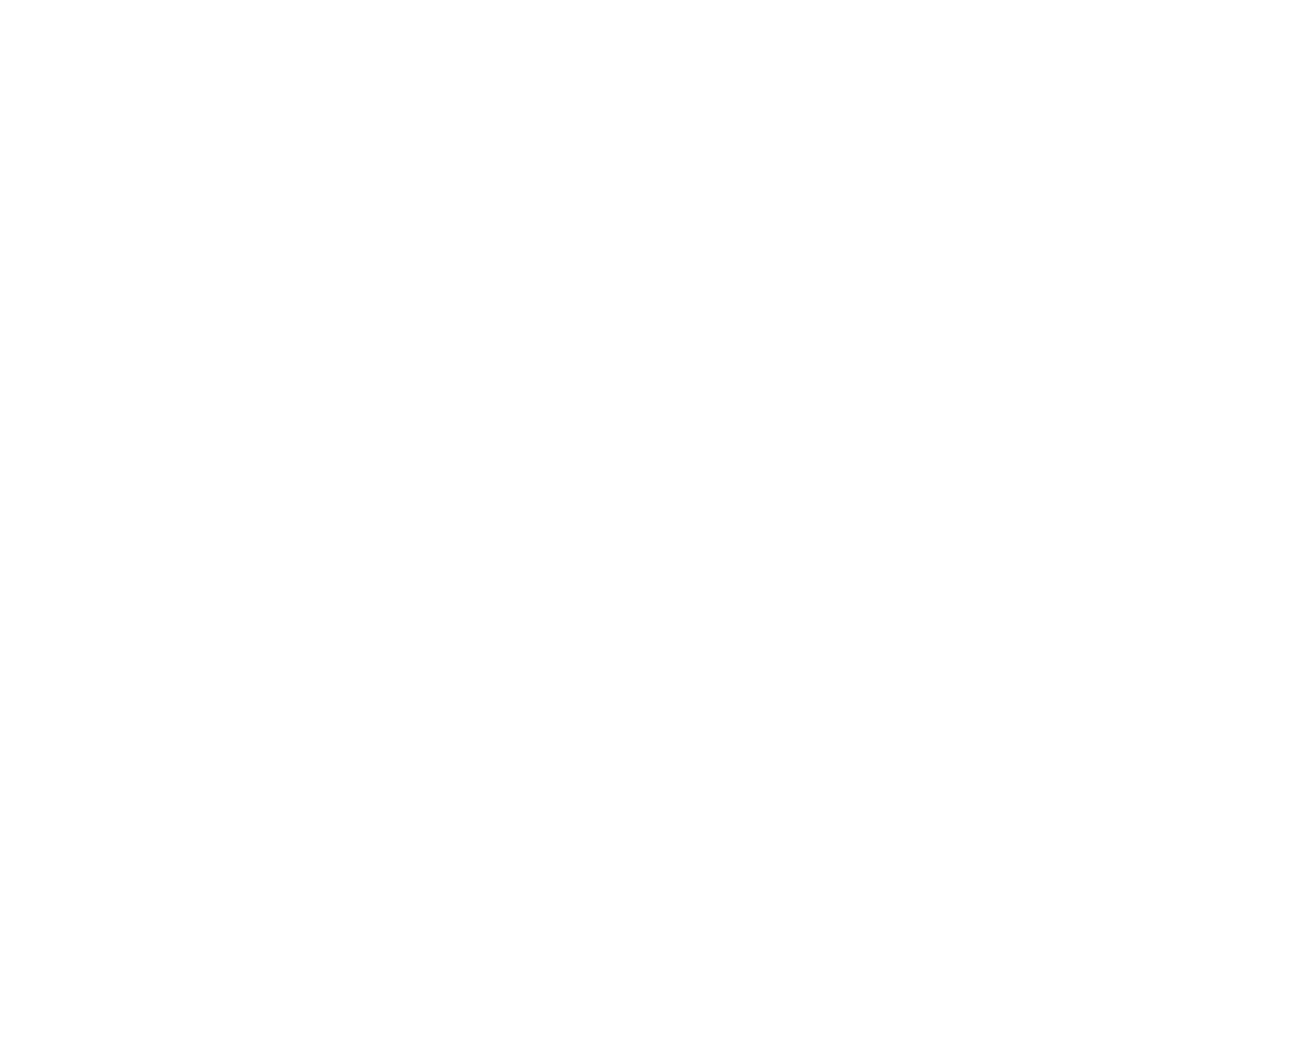

In [10]:
# evaluate the network|
dlc.evaluate_network(config_path, Shuffles=[2], plotting=True)

In [ ]:
dlc.analyze_videos?

In [17]:
test_vids

['D:\\DLC_projects\\vtuning_wirefree_DLC_22\\VTuningWF-Matt-2022-10-25\\test-videos\\11_04_2022_12_47_05_VTuningWF_MM_220915_a_free1_gabor.avi',
 'D:\\DLC_projects\\vtuning_wirefree_DLC_22\\VTuningWF-Matt-2022-10-25\\test-videos\\test_vid_1.mp4']

In [20]:
dlc.analyze_videos(config_path, [test_vids[-1]], shuffle=2, dynamic=(True, .1, 50), gputouse=0)

Config:
{'all_joints': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11]],
 'all_joints_names': ['mouseSnout',
                      'mouseBarL',
                      'mouseBarR',
                      'mouseBody1',
                      'mouseBody2',
                      'mouseBody3',
                      'mouseBase',
                      'miniscope',
                      'corner_UL',
                      'corner_UR',
                      'corner_BR',
                      'corner_BL'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-4\\UnaugmentedDataSet_VTuningWFOct25\\VTuningWF_Matt95shuffle2.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': 'C:\\Users\\mmccann\\Miniconda3\\envs\\DEEPLABCUT\\lib\\site-packages\\deeplabcut\\pose_estimation_tensorflow\\models\\pretrained\\resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_

Using snapshot-305000 for model D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\dlc-models\iteration-4\VTuningWFOct25-trainset95shuffle2
Activating extracting of PAFs
Starting to analyze %  D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos\test_vid_1.mp4
Loading  D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos\test_vid_1.mp4
Duration of video [s]:  91.72 , recorded with  25.0 fps!
Overall # of frames:  2293  found with (before cropping) frame dimensions:  1280 1024
Starting to extract posture from the video(s) with batchsize: 5


100%|███████████████████████████████████████████████████████████████████████████| 2293/2293 [03:02<00:00, 12.56it/s]


Video Analyzed. Saving results in D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos...


Config:
{'all_joints': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11]],
 'all_joints_names': ['mouseSnout',
                      'mouseBarL',
                      'mouseBarR',
                      'mouseBody1',
                      'mouseBody2',
                      'mouseBody3',
                      'mouseBase',
                      'miniscope',
                      'corner_UL',
                      'corner_UR',
                      'corner_BR',
                      'corner_BL'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-4\\UnaugmentedDataSet_VTuningWFOct25\\VTuningWF_Matt95shuffle2.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': 'C:\\Users\\mmccann\\Miniconda3\\envs\\DEEPLABCUT\\lib\\site-packages\\deeplabcut\\pose_estimation_tensorflow\\models\\pretrained\\resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_

Using snapshot-305000 for model D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\dlc-models\iteration-4\VTuningWFOct25-trainset95shuffle2
Processing...  D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos\test_vid_1.mp4
Analyzing D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos\test_vid_1DLC_resnet50_VTuningWFOct25shuffle2_305000.h5


2293it [00:00, 6114.82it/s]
2293it [00:00, 764327.99it/s]
C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\deeplabcut\refine_training_dataset\stitch.py:127: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(self.data[..., 3], axis=None, nan_policy="omit")[0][0]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos\test_vid_1.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


'DLC_resnet50_VTuningWFOct25shuffle2_305000'

In [27]:
dlc.filterpredictions?

In [28]:
dlc.filterpredictions(config_path, [test_vids[-1]], shuffle=2, filtertype='arima', p_bound=0.01, ARdegree=3, MAdegree=1, alpha=0.01)

Filtering with arima model D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos\test_vid_1.mp4


C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Saving filtered csv poses!


In [32]:
dlc.plot_trajectories?

Loading  D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos\test_vid_1.mp4 and data.


<IPython.core.display.Javascript object>


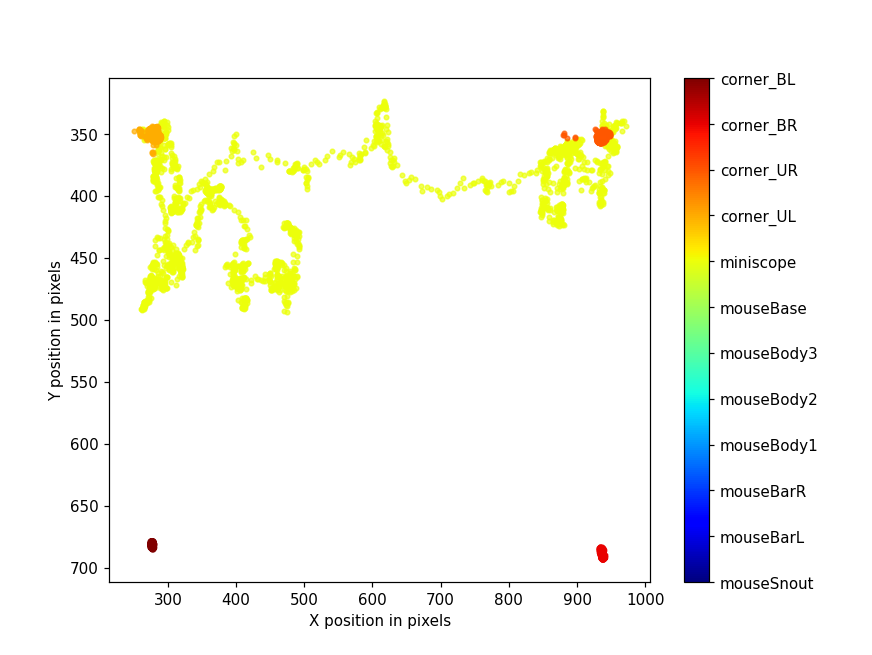

<IPython.core.display.Javascript object>


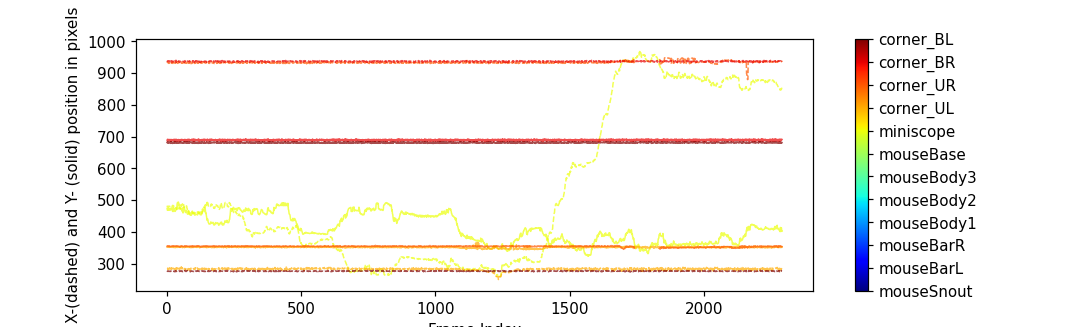

<IPython.core.display.Javascript object>


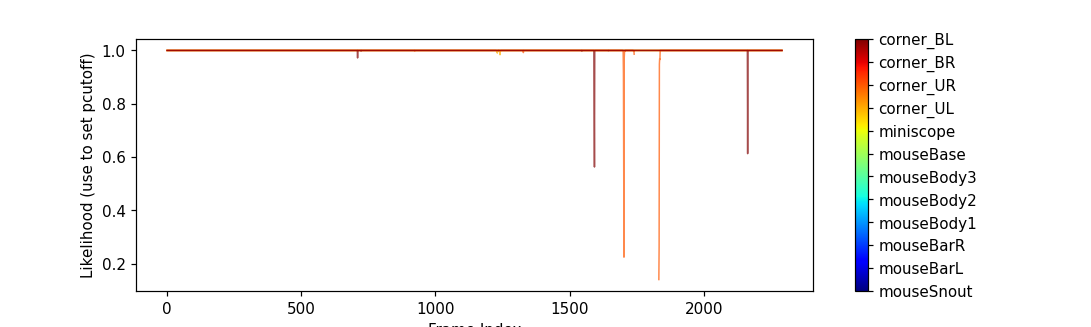

<IPython.core.display.Javascript object>


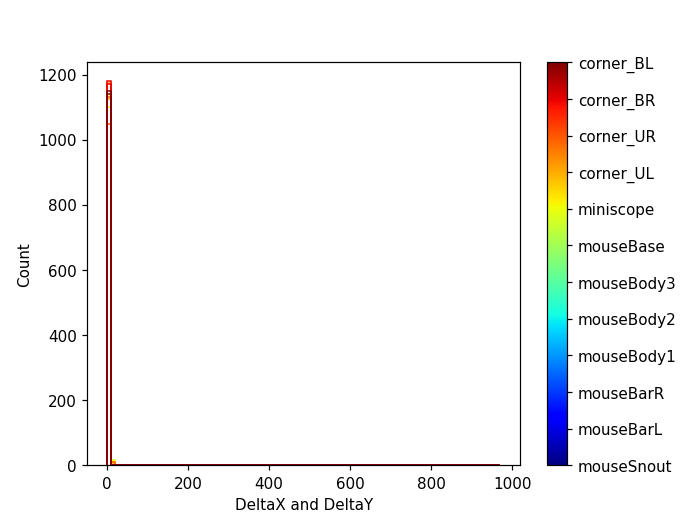

<IPython.core.display.Javascript object>


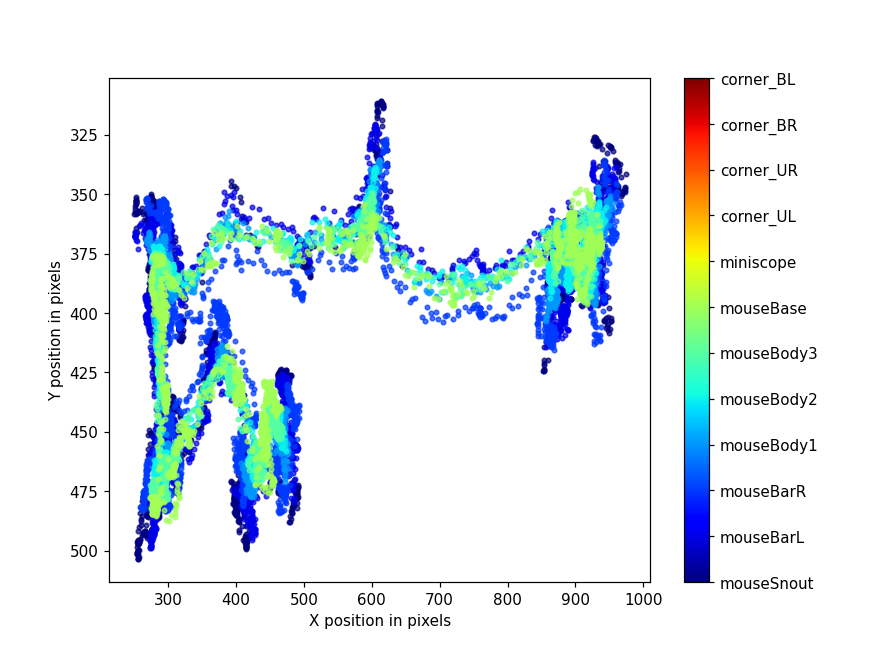

<IPython.core.display.Javascript object>


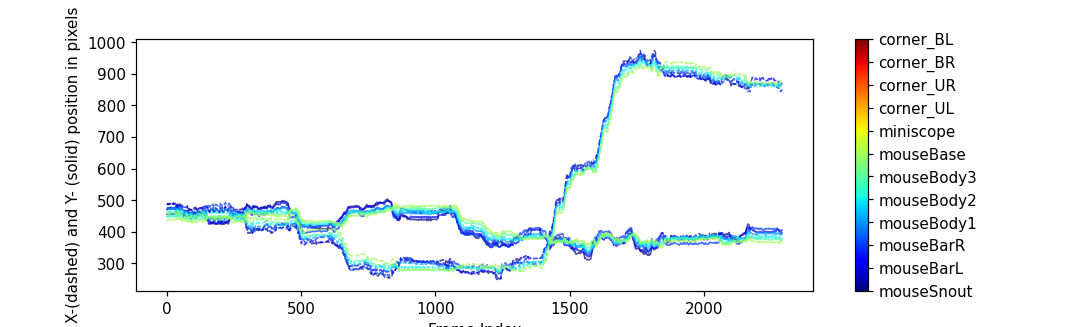

<IPython.core.display.Javascript object>


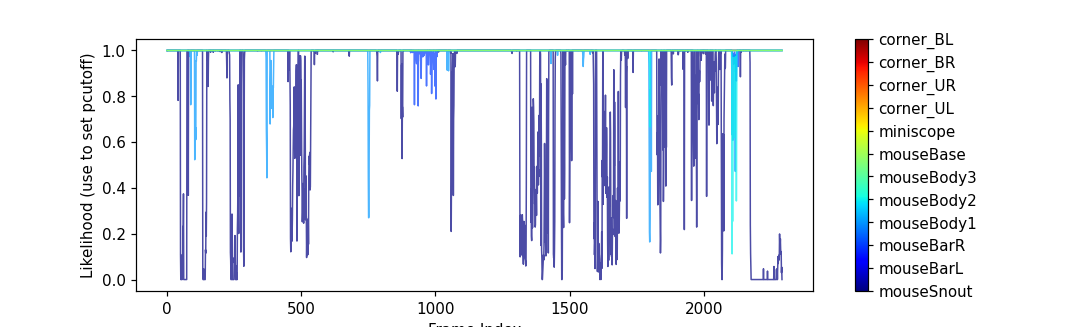

<IPython.core.display.Javascript object>


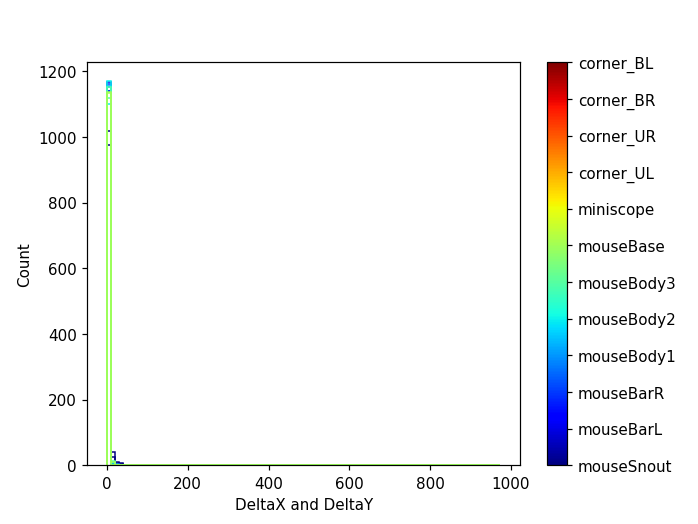

Plots created! Please check the directory "plot-poses" within the video directory


In [33]:
# Plot tracjectories
%matplotlib notebook
dlc.plot_trajectories(config_path, [test_vids[-1]], shuffle=2, showfigures=True)

In [22]:
dlc.create_labeled_video?

In [34]:
dlc.create_labeled_video(config_path, [test_vids[-1]], shuffle=2, filtered=True, draw_skeleton=True)

In [6]:
dlc.extract_outlier_frames?

C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\deeplabcut\refine_training_dataset\outlier_frames.py:401: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  sum_ = temp_dt.sum(axis=1, level=1)


No unfiltered data file found in D:\DLC_projects\vtuning_wirefree\VTuningWF-Matt-2022-10-25\videos for video 10_19_2022_14_14_19_VTuningWF_MM_220915_a_free0_wirefree_gabor_test and scorer DLC_resnet50_VTuningWFOct25shuffle1_105000 and ellipse tracker.
It seems the video has not been analyzed yet, or the video is not found! You can only refine the labels after the a video is analyzed. Please run 'analyze_video' first. Or, please double check your video file path
No unfiltered data file found in D:\DLC_projects\vtuning_wirefree\VTuningWF-Matt-2022-10-25\videos for video 10_20_2022_15_42_54_VTuningWF_MM_220915_a_free1_wirefree_gabor and scorer DLC_resnet50_VTuningWFOct25shuffle1_105000 and ellipse tracker.
It seems the video has not been analyzed yet, or the video is not found! You can only refine the labels after the a video is analyzed. Please run 'analyze_video' first. Or, please double check your video file path
No unfiltered data file found in D:\DLC_projects\vtuning_wirefree\VTuning

12868it [04:30, 47.62it/s]


Kmeans clustering ... (this might take a while)
Let's select frames indices: [26205, 25814, 18861, 9326, 19911, 22132, 27278, 31716, 31987, 13391]


<IPython.core.display.Javascript object>


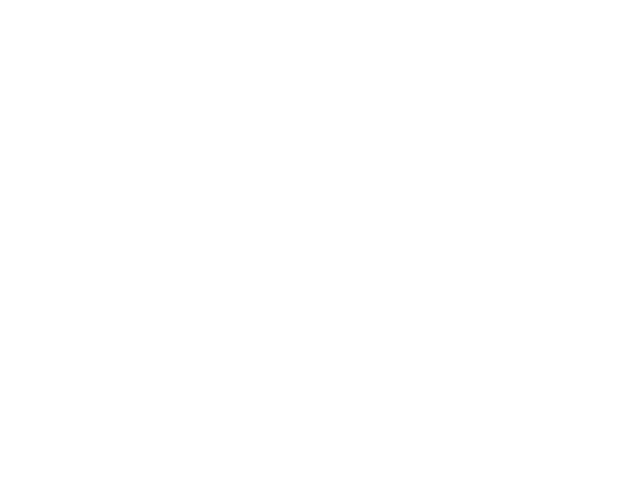

<IPython.core.display.Javascript object>


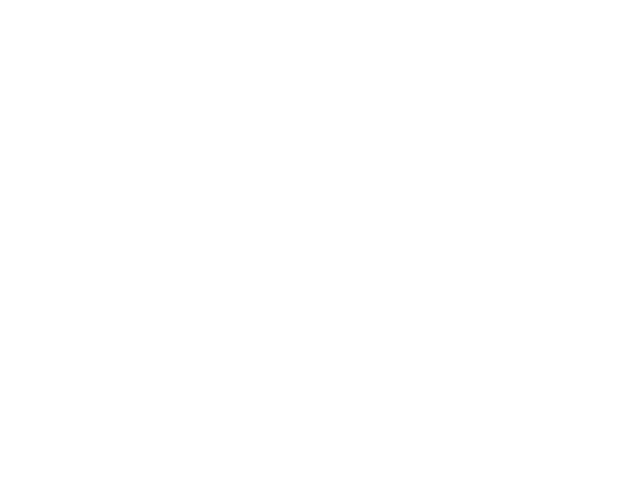

<IPython.core.display.Javascript object>


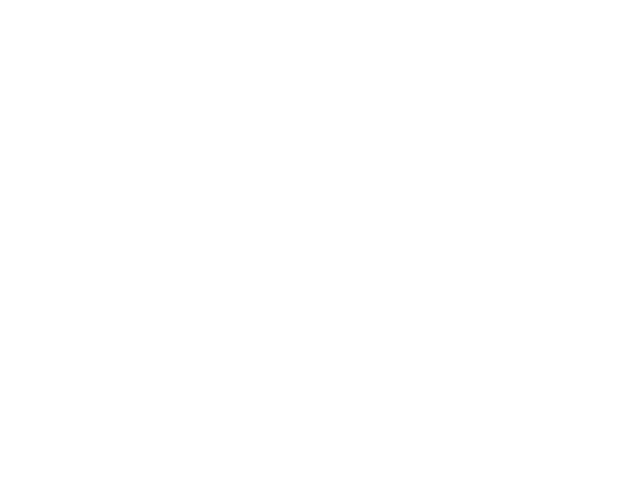

<IPython.core.display.Javascript object>


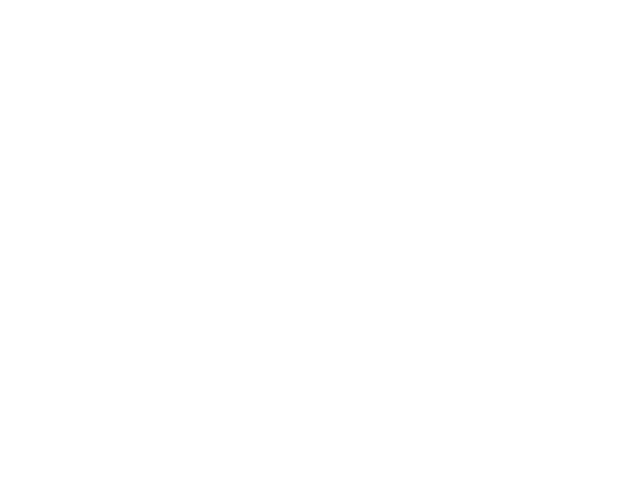

<IPython.core.display.Javascript object>


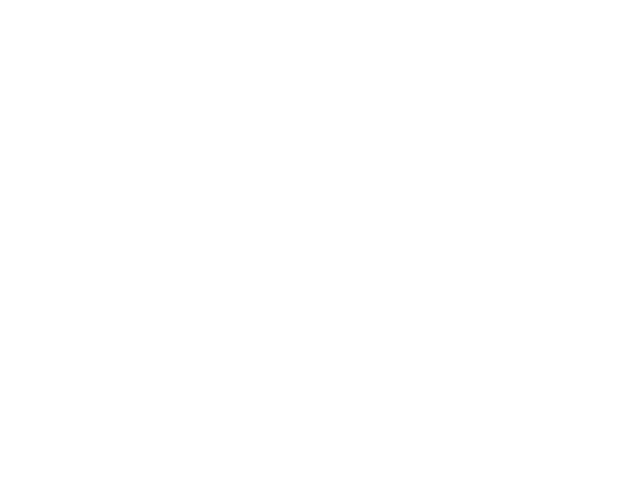

<IPython.core.display.Javascript object>


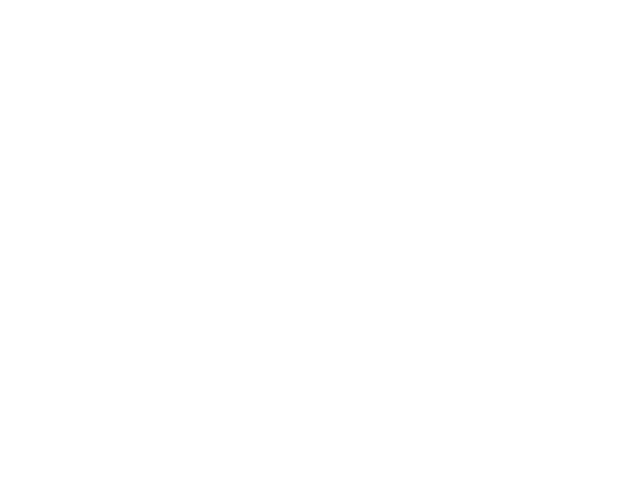

<IPython.core.display.Javascript object>


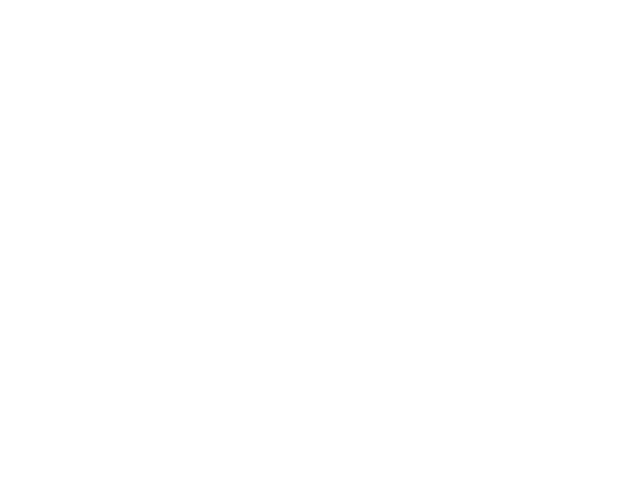

<IPython.core.display.Javascript object>


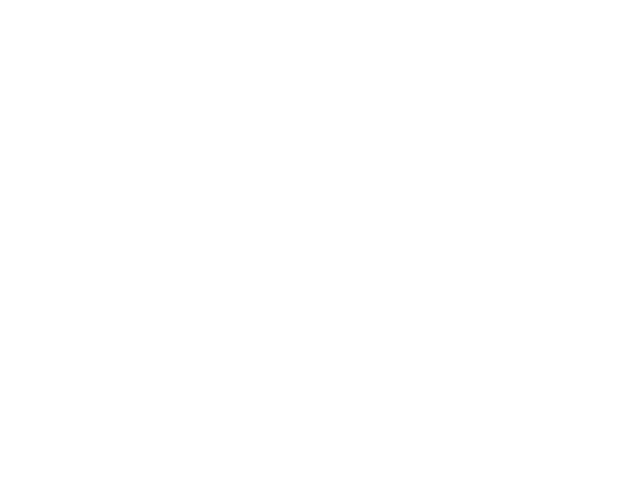

<IPython.core.display.Javascript object>


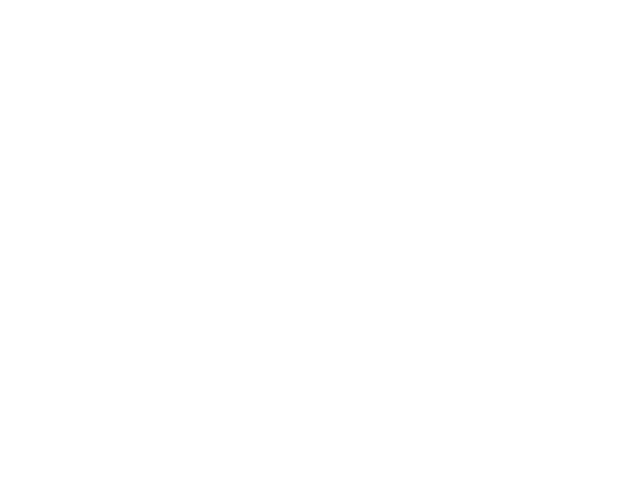

C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\deeplabcut\refine_training_dataset\outlier_frames.py:401: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  sum_ = temp_dt.sum(axis=1, level=1)


Attempting to create a symbolic link of the video ...
Created the symlink of D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos\11_04_2022_12_47_05_VTuningWF_MM_220915_a_free1_gabor.avi to D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\videos\11_04_2022_12_47_05_VTuningWF_MM_220915_a_free1_gabor.avi
New videos were added to the project! Use the function 'extract_frames' to select frames for labeling.
The outlier frames are extracted. They are stored in the subdirectory labeled-data\11_04_2022_12_47_05_VTuningWF_MM_220915_a_free1_gabor.
Once you extracted frames for all videos, use 'refine_labels' to manually correct the labels.
Method  jump  found  870  putative outlier frames.
Do you want to proceed with extracting  10  of those?
If this list is very large, perhaps consider changing the parameters (start, stop, p_bound, comparisonbodyparts) or use a different method.
yes/noy
Frames from video test_vid_1  already extracted (more will be add

870it [00:24, 34.82it/s]


Kmeans clustering ... (this might take a while)
Let's select frames indices: [147, 2094, 983, 1203, 2076, 738, 218, 1626, 376, 1947]


<IPython.core.display.Javascript object>


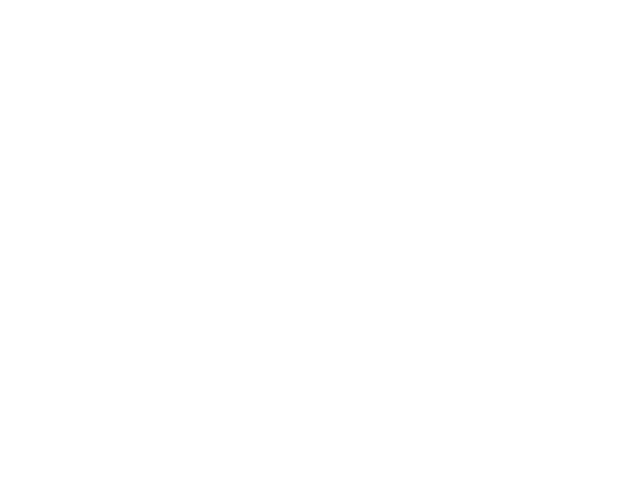

<IPython.core.display.Javascript object>


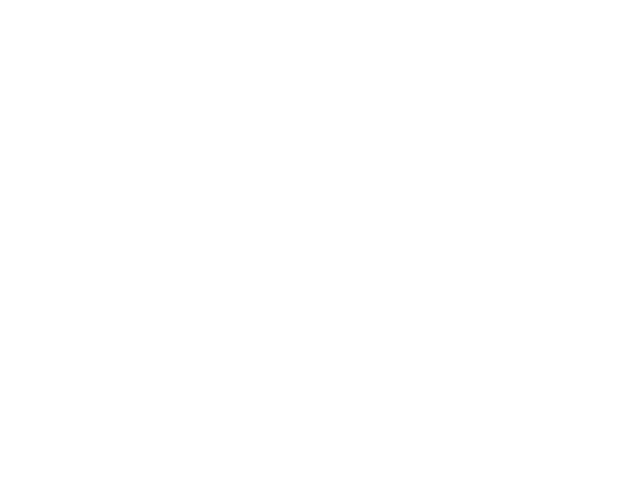

<IPython.core.display.Javascript object>


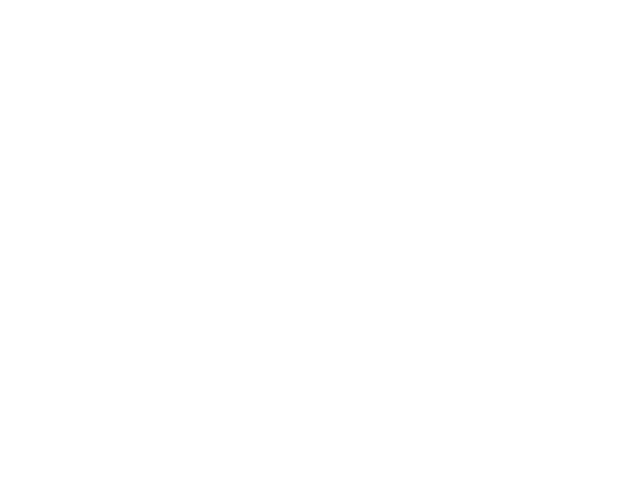

<IPython.core.display.Javascript object>


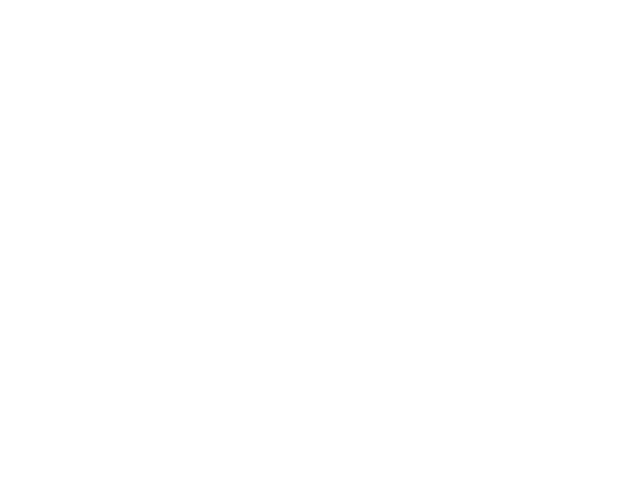

<IPython.core.display.Javascript object>


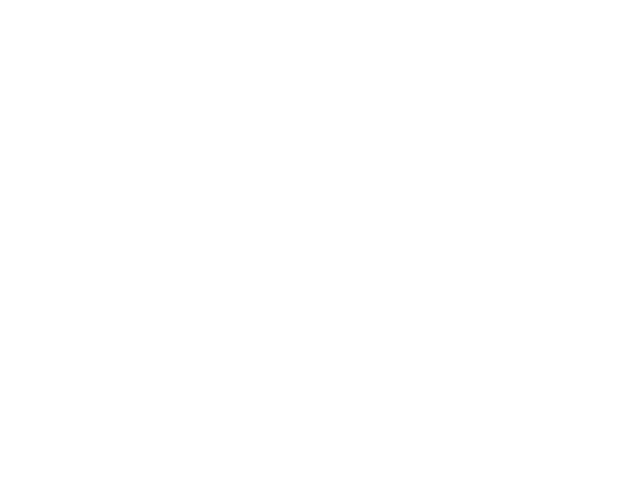

<IPython.core.display.Javascript object>


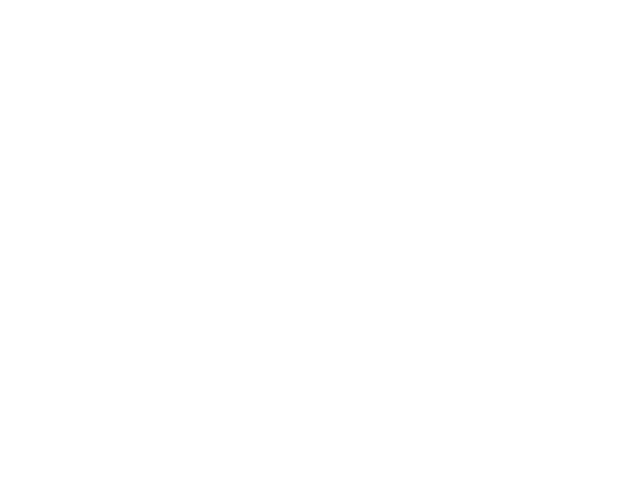

<IPython.core.display.Javascript object>


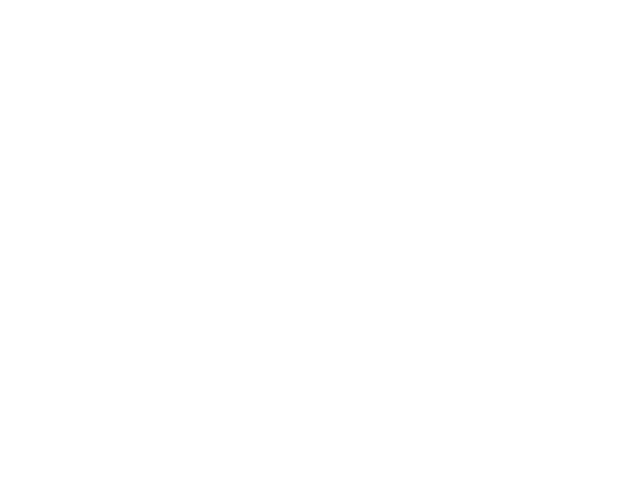

<IPython.core.display.Javascript object>


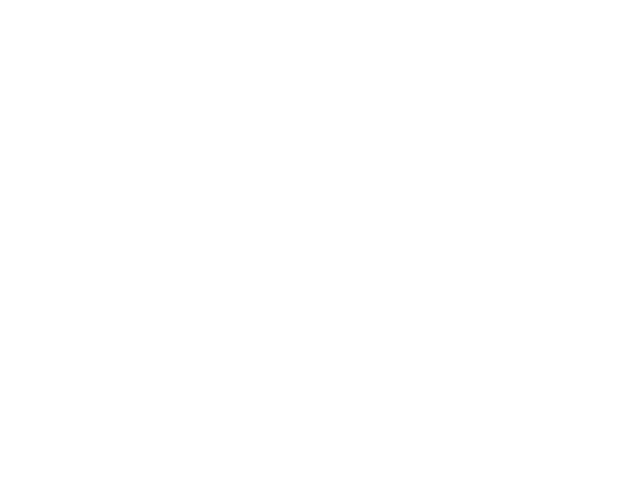

<IPython.core.display.Javascript object>


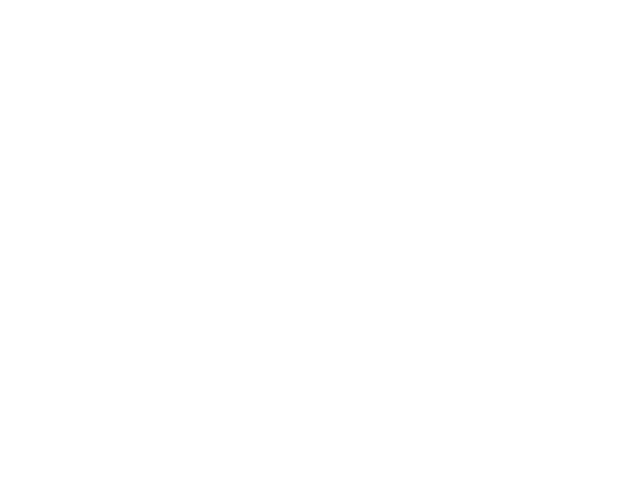

<IPython.core.display.Javascript object>


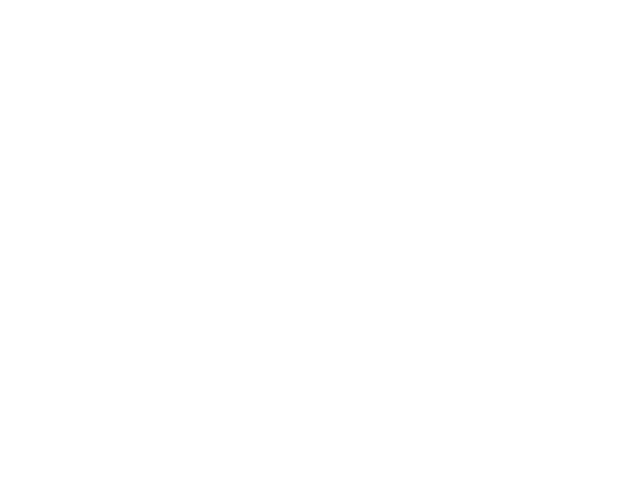

Attempting to create a symbolic link of the video ...
Symlink creation impossible (exFat architecture?): cutting/pasting the video instead.
AUTOMATIC ADDING OF VIDEO TO CONFIG FILE FAILED! You need to do this manually for including it in the config.yaml file!
Videopath: D:\DLC_projects\vtuning_wirefree_DLC_22\VTuningWF-Matt-2022-10-25\test-videos\test_vid_1.mp4 Coordinates for cropping: None
The outlier frames are extracted. They are stored in the subdirectory labeled-data\test_vid_1.
Once you extracted frames for all videos, use 'refine_labels' to manually correct the labels.


In [11]:
# extract outlier frames
# dlc.extract_outlier_frames(config_path, project_video_list, outlieralgorithm='uncertain', p_bound=0.6)
dlc.extract_outlier_frames(config_path, project_video_list,
                          outlieralgorithm='jump', epsilon=8)

In [13]:
dlc.refine_labels(config_path)

Checking labels if they are outside the image
A training dataset file is already found for this video. The refined machine labels are merged to this data!


C:\Users\mmccann\Miniconda3\envs\DEEPLABCUT\lib\site-packages\deeplabcut\gui\multiple_individuals_refinement_toolbox.py:817: FutureWarning: inplace is deprecated and will be removed in a future version.
  self.Dataframe.columns.set_levels(


Closing... The refined labels are stored in a subdirectory under labeled-data. Use the function 'merge_datasets' to augment the training dataset, and then re-train a network using create_training_dataset followed by train_network!


In [15]:
# Merge the dataset, then move to check labels and retrain
dlc.merge_datasets(config_path)

Merged data sets and updated refinement iteration to 4.
Now you can create a new training set for the expanded annotated images (use create_training_dataset).
